# Modelo Híbrido para Predicción de COVID-19 (MEJORADO v2.0)

## 🚀 MEJORAS IMPLEMENTADAS

### **Clasificador XGBoost:**
- ✅ **Balanceo de clases** (más peso a subidas minoritarias)
- ✅ **Umbrales asimétricos**: -0.05 bajada vs +0.08 subida
- ✅ **24 features de tendencia** (vs 16 original):
  - Jerk (aceleración de 2º orden)
  - Cruces de medias móviles (señales alcistas/bajistas)
  - Detección de extremos locales (mínimos/máximos)
  - Momentum de 7 y 14 días
  - Volatilidad comparativa
  - Días consecutivos en misma dirección
- ✅ Más árboles (150 vs 100) y más profundos (depth=6 vs 5)

### **Predictor LSTM:**
- ✅ **LSTM profundo**: 64 hidden units, 2 capas (vs 32/1)
- ✅ **Dropout 0.2** para regularización
- ✅ **Attention Mechanism** (aprende qué días importan más)
- ✅ **Loss Adaptativa** (penaliza más errores en cambios grandes)
- ✅ **Features exógenas** (si disponibles): casos + muertes + reproducción + positividad

### **Objetivo**: Direction Accuracy > 70% (baseline: 54%)

---

## Flujo Completo:
1. **Carga de datos** → Filtrado de países desde paises_incluidos.txt
2. **Preprocesamiento** → Interpolación + Suavizado
3. **Clustering KMeans** → Agrupar países por características socioeconómicas
4. **División estratificada** → Train/Val/Test heterogéneos
5. **Mapa de visualización** → Países coloreados por cluster
6. **Modelo Híbrido MEJORADO** → XGBoost + LSTM con Attention
7. **Evaluación** → Métricas y visualizaciones

## 1. Imports y Configuración

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Agregar el directorio del modelo al path
import sys
from pathlib import Path
modelo_dir = Path('..') / 'modelo'
sys.path.insert(0, str(modelo_dir.resolve()))


# Mapa
import geopandas as gpd

# Modelo híbrido
from config import HybridConfig
from hybrid_model import HybridCOVIDModel
from training_pipeline import prepare_data_from_dict
from evaluation import plot_predictions_vs_actual, plot_metrics_by_horizon

from feature_engineering import (
    calculate_regime_from_window_batch,
    calculate_regime_labels_batch,
    detect_regime_transitions
)
from evaluation import plot_transition_analysis
from config import HybridConfig

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports completados")

✓ Imports completados


## 2. Configuración de Preprocesamiento

In [ ]:
class PreprocessConfig:
    """Configuración de preprocesamiento"""
    
    # Columnas para clustering
    COLUMNAS_CLUSTERING = [
        "population_density",
        "median_age",
        "life_expectancy",
        "gdp_per_capita",
        "extreme_poverty",
        "diabetes_prevalence",
        "handwashing_facilities",
        "hospital_beds_per_thousand"
    ]
    
    # Clustering
    NUM_CLUSTERS = 6
    RANDOM_STATE = 42
    
    # División de datos
    TRAIN_PCT = 0.7
    VAL_PCT = 0.15
    TEST_PCT = 0.15
    
    # Datos temporales
    MIN_DAYS = 300  # Mínimo de días con datos
    WINDOW_ROLLING = 7  # Ventana para media móvil
    
    # Paths
    PAISES_FILE = "../paises_incluidos.txt"
    COVID_URL = "https://catalog.ourworldindata.org/garden/covid/latest/compact/compact.csv"
    SHAPEFILE_PATH = "../MAPA/ne_10m_admin_0_countries.shp"

print("✓ Configuración cargada")

✓ Configuración cargada


## 3. Carga de Datos

In [3]:
# Cargar dataset de COVID
print("Descargando datos de COVID-19...")
df = pd.read_csv(PreprocessConfig.COVID_URL)

print(f"✓ Dataset cargado: {df.shape}")
print(f"Columnas: {df.columns.tolist()[:10]}...")

Descargando datos de COVID-19...
✓ Dataset cargado: (533674, 61)
Columnas: ['country', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths', 'new_deaths']...


## 4. Filtrado de Países

In [4]:
# # Cargar lista de países incluidos
# with open(PreprocessConfig.PAISES_FILE, "r", encoding="utf-8") as f:
#     paises_incluidos = [line.strip() for line in f if line.strip()]

# print(f"Países a incluir: {len(paises_incluidos)}")
# print(f"Ejemplos: {paises_incluidos[:10]}")

# # Filtrar DataFrame
# df = df[df["country"].isin(paises_incluidos)].copy()

# print(f"\n✓ Filas después del filtrado: {len(df)}")
# print(f"Países únicos: {df['country'].nunique()}")

## 5. Transformación y Normalización

In [5]:
# Transformación logarítmica
df["new_cases_smoothed_per_million_log"] = np.log1p(df["new_cases_smoothed_per_million"])

# Normalización por país (Z-score)
df["new_cases_smoothed_per_million_norm"] = df.groupby("country")["new_cases_smoothed_per_million_log"].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

print("✓ Transformación logarítmica y normalización completadas")
print(f"Media normalizada: {df['new_cases_smoothed_per_million_norm'].mean():.4f}")
print(f"Std normalizada: {df['new_cases_smoothed_per_million_norm'].std():.4f}")

✓ Transformación logarítmica y normalización completadas
Media normalizada: 0.0000
Std normalizada: 0.9841


## 6. Crear Diccionario de Países

In [6]:
paises = df["country"].unique()
dic_paises = {}

for pais in paises:
    df_temp = df[df["country"] == pais].copy()
    
    # Convertir a datetime y ordenar
    df_temp["date"] = pd.to_datetime(df_temp["date"])
    df_temp = df_temp.sort_values("date")
    df_temp.set_index("date", inplace=True)
    
    # Eliminar columna 'country' (ya no necesaria)
    df_temp = df_temp.drop('country', axis=1, errors='ignore')
    
    dic_paises[pais] = df_temp

print(f"✓ Diccionario de países creado: {len(dic_paises)} países")
print(f"\nEjemplo - {paises[0]}:")
print(f"  Shape: {dic_paises[paises[0]].shape}")
print(f"  Fecha inicio: {dic_paises[paises[0]].index.min()}")
print(f"  Fecha fin: {dic_paises[paises[0]].index.max()}")

✓ Diccionario de países creado: 262 países

Ejemplo - Afghanistan:
  Shape: (2091, 61)
  Fecha inicio: 2020-01-01 00:00:00
  Fecha fin: 2025-09-21 00:00:00


## 7. Preprocesamiento Temporal

In [7]:
print("Aplicando preprocesamiento temporal...")

for pais in list(dic_paises.keys()):
    df_pais = dic_paises[pais]
    
    # 1) Frecuencia diaria uniforme
    df_pais = df_pais.resample('D').asfreq()
    
    # 2) Solo columnas numéricas
    num_cols = df_pais.select_dtypes(include="number").columns
    
    # 3) Interpolación lineal y relleno de extremos
    df_pais[num_cols] = (
        df_pais[num_cols]
        .interpolate(method='linear')
        .ffill()  # Forward fill
        .bfill()  # Backward fill
    )
    
    # 4) Suavizado con media móvil
    df_pais[num_cols] = df_pais[num_cols].rolling(
        window=PreprocessConfig.WINDOW_ROLLING, 
        min_periods=1
    ).mean()
    
    # Actualizar en diccionario
    dic_paises[pais] = df_pais

print("✓ Preprocesamiento temporal completado")
print("  - Frecuencia diaria uniforme")
print("  - Interpolación lineal")
print(f"  - Media móvil (ventana={PreprocessConfig.WINDOW_ROLLING})")

Aplicando preprocesamiento temporal...
✓ Preprocesamiento temporal completado
  - Frecuencia diaria uniforme
  - Interpolación lineal
  - Media móvil (ventana=7)


## 8. Filtrar Países con Datos Suficientes

In [8]:
# Filtrar países con al menos MIN_DAYS días de datos
paises_validos = {}

for pais, df_pais in dic_paises.items():
    # Verificar que tenga la columna necesaria
    if 'new_cases_smoothed_per_million' not in df_pais.columns:
        continue
    
    # Contar días con datos no nulos
    dias_validos = df_pais['new_cases_smoothed_per_million'].notna().sum()
    
    if dias_validos >= PreprocessConfig.MIN_DAYS:
        paises_validos[pais] = df_pais

dic_paises = paises_validos

print(f"✓ Países con al menos {PreprocessConfig.MIN_DAYS} días: {len(dic_paises)}")
print(f"\nPaíses válidos: {list(dic_paises.keys())[:15]}...")

✓ Países con al menos 300 días: 249

Países válidos: ['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia', 'Asia excl. China', 'Australia']...


## 9. Crear DataFrame de Propiedades Socioeconómicas

In [9]:
def crear_df_propiedades_paises(dic_paises: dict, columnas: list) -> pd.DataFrame:
    """
    Crea un DataFrame con propiedades promedio de cada país.
    
    Args:
        dic_paises: Diccionario con DataFrames por país
        columnas: Lista de columnas a promediar
    
    Returns:
        DataFrame con país, numeroDatos y promedios de columnas
    """
    data = []
    
    for pais, df_pais in dic_paises.items():
        row = {'pais': pais, 'numeroDatos': len(df_pais)}
        
        for col in columnas:
            if col in df_pais.columns:
                row[col] = df_pais[col].mean()
            else:
                row[col] = np.nan
        
        data.append(row)
    
    return pd.DataFrame(data)

# Crear DataFrame
df_paises = crear_df_propiedades_paises(dic_paises, PreprocessConfig.COLUMNAS_CLUSTERING)

print(f"✓ DataFrame de propiedades creado: {df_paises.shape}")
print(f"\nColumnas: {df_paises.columns.tolist()}")
print(f"\nPrimeras filas:")
df_paises.head()

✓ DataFrame de propiedades creado: (249, 10)

Columnas: ['pais', 'numeroDatos', 'population_density', 'median_age', 'life_expectancy', 'gdp_per_capita', 'extreme_poverty', 'diabetes_prevalence', 'handwashing_facilities', 'hospital_beds_per_thousand']

Primeras filas:


,pais,numeroDatos,population_density,median_age,life_expectancy,gdp_per_capita,extreme_poverty,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand
0,Afghanistan,2091,62.215549,16.752001,65.616997,1516.273315,NaN,10.900000,48.214695,0.39
1,Africa,2088,48.355656,18.893999,62.920502,NaN,NaN,NaN,NaN,NaN
2,Albania,2192,103.197594,35.943001,78.768799,15492.067383,0.340922,10.200000,NaN,2.89
3,Algeria,2192,19.094181,27.983000,76.128899,11198.233398,0.000000,7.100000,84.804100,1.90
4,American Samoa,2088,241.824997,27.927000,72.752098,NaN,NaN,20.299999,NaN,NaN


## 10. Limpiar Datos Faltantes

In [10]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
print(df_paises.isnull().sum())

# Eliminar países con demasiados valores faltantes
umbral_faltantes = 3  # Máximo de columnas con valores faltantes
df_paises = df_paises[df_paises[PreprocessConfig.COLUMNAS_CLUSTERING].isnull().sum(axis=1) <= umbral_faltantes]

# Rellenar valores faltantes restantes con la mediana
for col in PreprocessConfig.COLUMNAS_CLUSTERING:
    if df_paises[col].isnull().any():
        mediana = df_paises[col].median()
        df_paises[col].fillna(mediana, inplace=True)
        print(f"  {col}: rellenado con mediana = {mediana:.2f}")

print(f"\n✓ Países restantes: {len(df_paises)}")

Valores faltantes por columna:
pais                            0
numeroDatos                     0
population_density              9
median_age                      8
life_expectancy                 7
gdp_per_capita                 52
extreme_poverty                87
diabetes_prevalence            36
handwashing_facilities        134
hospital_beds_per_thousand     95
dtype: int64
  gdp_per_capita: rellenado con mediana = 14517.77
  extreme_poverty: rellenado con mediana = 2.82
  diabetes_prevalence: rellenado con mediana = 7.40
  handwashing_facilities: rellenado con mediana = 70.15
  hospital_beds_per_thousand: rellenado con mediana = 2.60

✓ Países restantes: 202


## 11. Clustering con KMeans

In [11]:
# Seleccionar columnas numéricas para clustering
X_clustering = df_paises[PreprocessConfig.COLUMNAS_CLUSTERING].values

# Normalizar con StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Aplicar KMeans
kmeans = KMeans(
    n_clusters=PreprocessConfig.NUM_CLUSTERS, 
    random_state=PreprocessConfig.RANDOM_STATE,
    n_init=10
)
df_paises['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"✓ KMeans aplicado con {PreprocessConfig.NUM_CLUSTERS} clusters")
print(f"\nDistribución de clusters:")
print(df_paises['Cluster'].value_counts().sort_index())

print(f"\nEjemplos por cluster:")
for cluster in range(PreprocessConfig.NUM_CLUSTERS):
    paises_cluster = df_paises[df_paises['Cluster'] == cluster]['pais'].tolist()[:5]
    print(f"  Cluster {cluster}: {paises_cluster}")

✓ KMeans aplicado con 5 clusters

Distribución de clusters:
Cluster
0    35
1    45
2    31
3    90
4     1
Name: count, dtype: int64

Ejemplos por cluster:
  Cluster 0: ['Argentina', 'Armenia', 'Austria', 'Azerbaijan', 'Barbados']
  Cluster 1: ['Angola', 'Benin', 'Bolivia', 'Burkina Faso', 'Burundi']
  Cluster 2: ['Aruba', 'Australia', 'Bahrain', 'Bermuda', 'Brunei']
  Cluster 3: ['Afghanistan', 'Albania', 'Algeria', 'Antigua and Barbuda', 'Bahamas']
  Cluster 4: ['Monaco']


## 11.1 Crear Mapping de Clusters para el Modelo Híbrido

In [12]:
# Crear diccionario: {nombre_pais: cluster_id}
cluster_mapping = dict(zip(df_paises['pais'], df_paises['Cluster']))

print(f"✓ Cluster mapping creado para {len(cluster_mapping)} países")
print(f"\nEjemplos:")
for pais in list(cluster_mapping.keys())[:5]:
    print(f"  {pais}: Cluster {cluster_mapping[pais]}")

# Verificar distribución
import numpy as np
unique_clusters, counts = np.unique(list(cluster_mapping.values()), return_counts=True)
print(f"\nDistribución de clusters:")
for cluster_id, count in zip(unique_clusters, counts):
    print(f"  Cluster {cluster_id}: {count} países")

✓ Cluster mapping creado para 202 países

Ejemplos:
  Afghanistan: Cluster 3
  Albania: Cluster 3
  Algeria: Cluster 3
  Angola: Cluster 1
  Antigua and Barbuda: Cluster 3

Distribución de clusters:
  Cluster 0: 35 países
  Cluster 1: 45 países
  Cluster 2: 31 países
  Cluster 3: 90 países
  Cluster 4: 1 países


## 12. Visualización de Clusters (Scatter Plots)

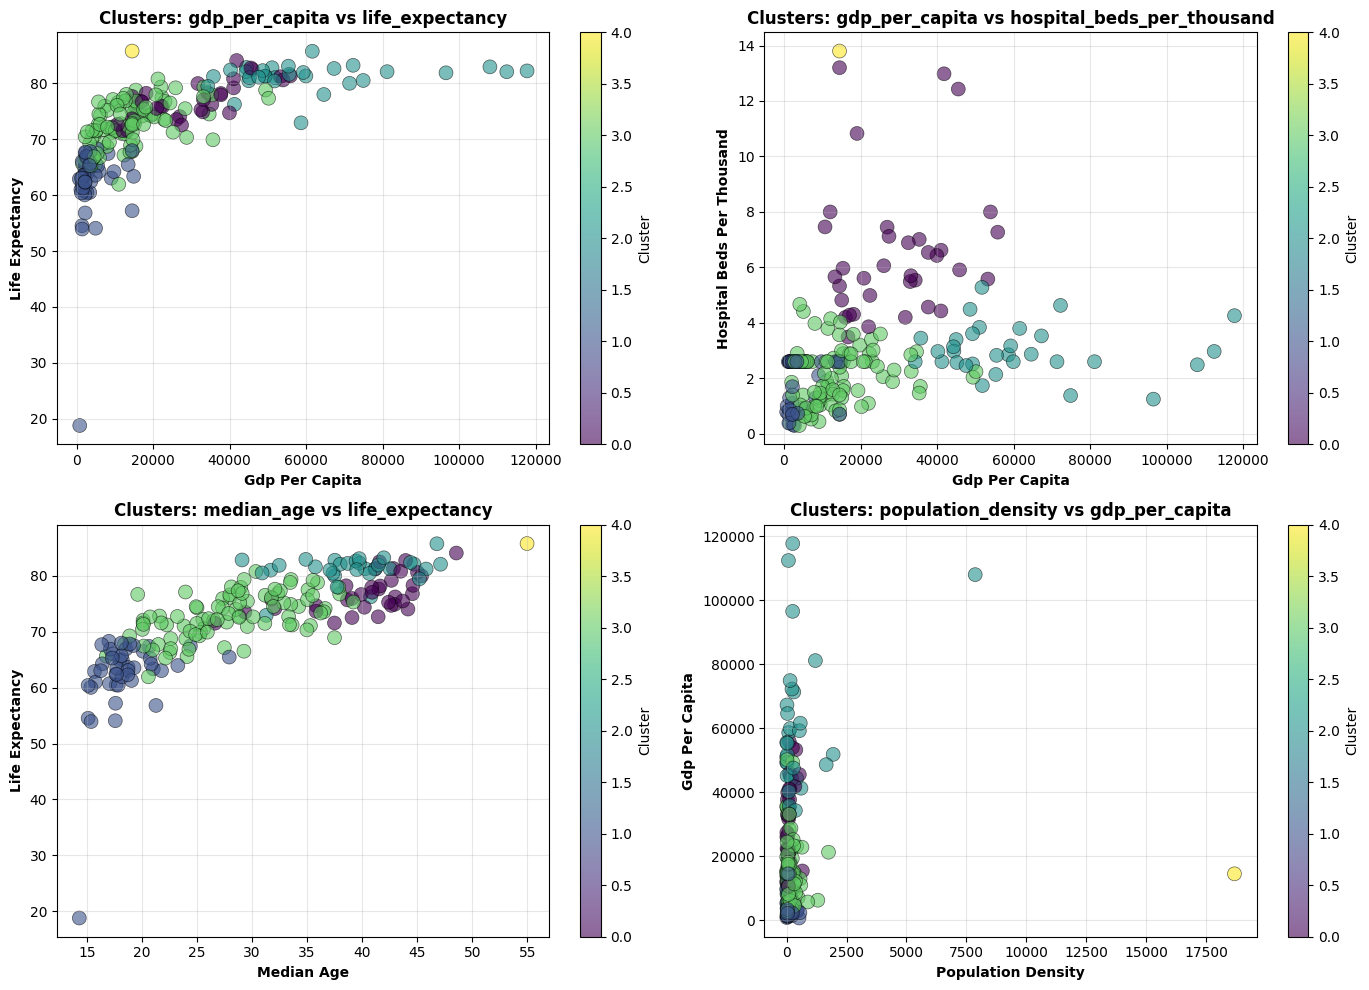

✓ Scatter plots de clusters generados


In [13]:
# Seleccionar pares de variables más representativos
pairs = [
    ('gdp_per_capita', 'life_expectancy'),
    ('gdp_per_capita', 'hospital_beds_per_thousand'),
    ('median_age', 'life_expectancy'),
    ('population_density', 'gdp_per_capita')
]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, (var1, var2) in enumerate(pairs):
    scatter = axs[i].scatter(
        df_paises[var1], 
        df_paises[var2], 
        c=df_paises['Cluster'], 
        cmap='viridis',
        s=100,
        alpha=0.6,
        edgecolors='black',
        linewidths=0.5
    )
    axs[i].set_xlabel(var1.replace('_', ' ').title(), fontweight='bold')
    axs[i].set_ylabel(var2.replace('_', ' ').title(), fontweight='bold')
    axs[i].set_title(f'Clusters: {var1} vs {var2}', fontweight='bold')
    axs[i].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axs[i], label='Cluster')

plt.tight_layout()
plt.show()

print("✓ Scatter plots de clusters generados")

## 13. División Estratificada Train/Val/Test

In [14]:
def split_estratificado_por_cluster(df_paises, train_pct=0.7, val_pct=0.15, test_pct=0.15, random_state=42):
    """
    Divide países en train/val/test manteniendo representación de todos los clusters.
    
    Args:
        df_paises: DataFrame con columnas 'pais', 'Cluster', 'numeroDatos'
        train_pct: Porcentaje para training
        val_pct: Porcentaje para validation
        test_pct: Porcentaje para test
        random_state: Semilla aleatoria
    
    Returns:
        DataFrame con columna 'dataset' añadida
    """
    df = df_paises.copy().sort_values(by='Cluster')
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    for cluster in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster]
        
        # Si cluster muy pequeño, todo a train
        if len(cluster_data) < 3:
            train_indices.extend(cluster_data.index)
            continue
        
        # División estratificada
        cluster_train, cluster_temp = train_test_split(
            cluster_data,
            test_size=(val_pct + test_pct),
            random_state=random_state
        )
        
        # Si temp muy pequeño, dividir mitad y mitad
        if len(cluster_temp) < 2:
            val_indices.extend(cluster_temp.index)
        else:
            cluster_val, cluster_test = train_test_split(
                cluster_temp,
                test_size=test_pct / (val_pct + test_pct),
                random_state=random_state
            )
            val_indices.extend(cluster_val.index)
            test_indices.extend(cluster_test.index)
        
        train_indices.extend(cluster_train.index)
    
    # Asignar dataset
    df['dataset'] = 'test'
    df.loc[train_indices, 'dataset'] = 'train'
    df.loc[val_indices, 'dataset'] = 'val'
    
    return df

# Aplicar división
df_paises = split_estratificado_por_cluster(
    df_paises,
    train_pct=PreprocessConfig.TRAIN_PCT,
    val_pct=PreprocessConfig.VAL_PCT,
    test_pct=PreprocessConfig.TEST_PCT,
    random_state=PreprocessConfig.RANDOM_STATE
)

print("✓ División estratificada completada")
print(f"\nDistribución:")
print(df_paises['dataset'].value_counts())

# Estadísticas detalladas
total_paises = len(df_paises)
total_datos = df_paises['numeroDatos'].sum()

for dataset in ['train', 'val', 'test']:
    df_subset = df_paises[df_paises['dataset'] == dataset]
    pct_paises = (len(df_subset) / total_paises) * 100
    pct_datos = (df_subset['numeroDatos'].sum() / total_datos) * 100
    print(f"\n{dataset.upper()}:")
    print(f"  Países: {len(df_subset)} ({pct_paises:.1f}%)")
    print(f"  Datos temporales: {df_subset['numeroDatos'].sum()} ({pct_datos:.1f}%)")
    print(f"  Clusters representados: {df_subset['Cluster'].nunique()}/{PreprocessConfig.NUM_CLUSTERS}")

✓ División estratificada completada

Distribución:
dataset
train    140
test      32
val       30
Name: count, dtype: int64

TRAIN:
  Países: 140 (69.3%)
  Datos temporales: 300061 (69.3%)
  Clusters representados: 5/5

VAL:
  Países: 30 (14.9%)
  Datos temporales: 64515 (14.9%)
  Clusters representados: 4/5

TEST:
  Países: 32 (15.8%)
  Datos temporales: 68691 (15.9%)
  Clusters representados: 4/5


## 14. Mapa Mundial con Clusters

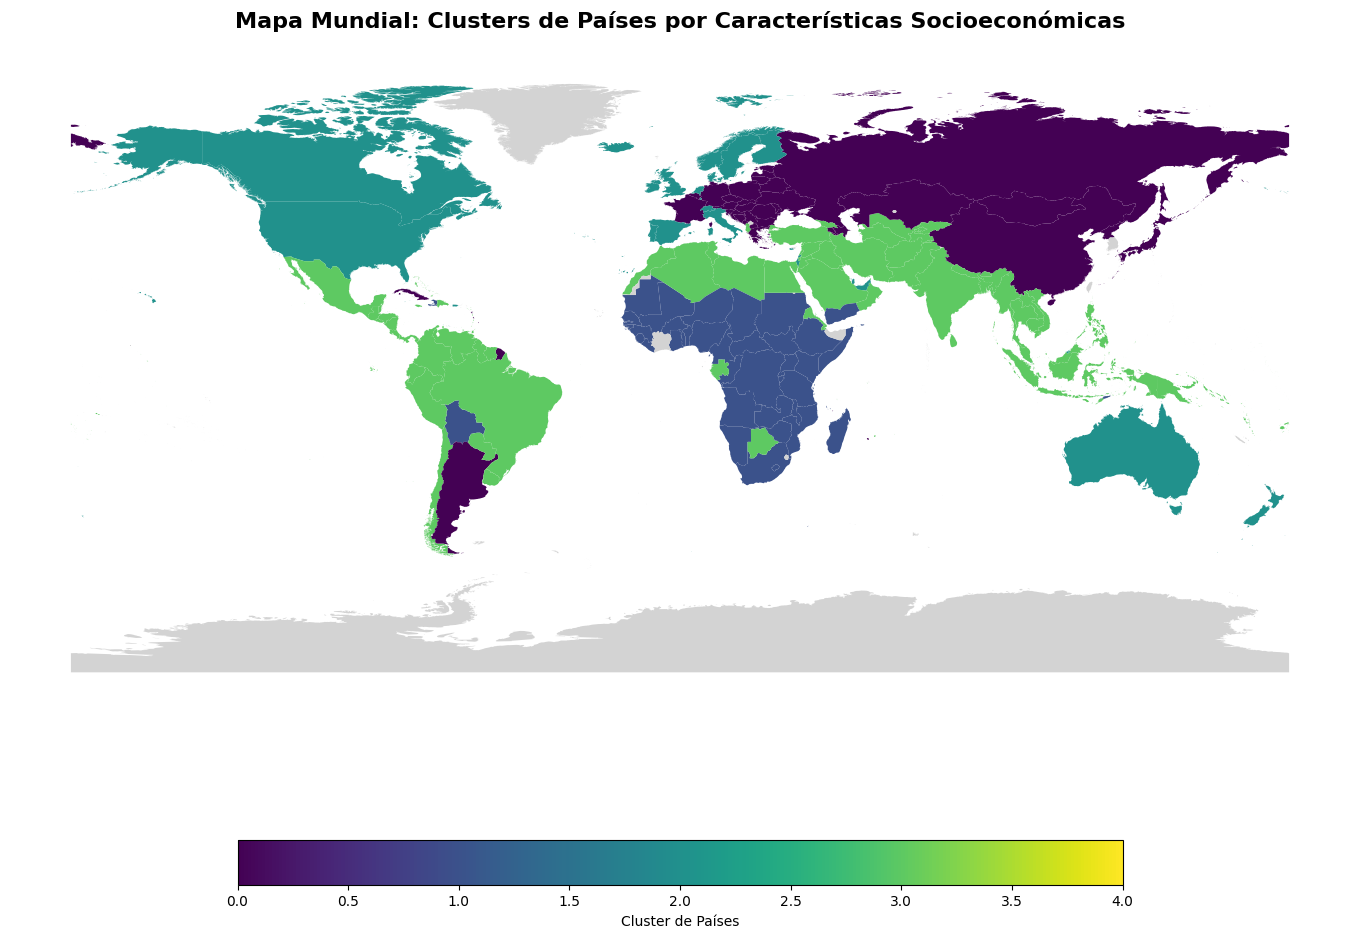

✓ Mapa generado exitosamente
  Países mapeados: 191
  Países sin mapear: 67


In [15]:
# Cargar shapefile
try:
    world = gpd.read_file(PreprocessConfig.SHAPEFILE_PATH)
    world = world.rename(columns={'ADMIN': 'pais'})
    
    # Mapeo de nombres (para compatibilidad)
    mapeo_nombres = {
        'United States': 'United States of America',
        'South Korea': 'Republic of Korea',
        'Eswatini': 'Swaziland',
        'Cabo Verde': 'Cape Verde',
        'Cote d\'Ivoire': 'Ivory Coast',
        'Democratic Republic of Congo': 'Democratic Republic of the Congo',
        'Congo': 'Republic of the Congo',
        'Serbia': 'Republic of Serbia',
        'Tanzania': 'United Republic of Tanzania',
        'Bahamas': 'The Bahamas'
    }
    
    df_paises_map = df_paises.copy()
    df_paises_map['pais'] = df_paises_map['pais'].replace(mapeo_nombres)
    
    # Normalizar nombres (minúsculas)
    df_paises_map['pais'] = df_paises_map['pais'].str.lower()
    world['pais'] = world['pais'].str.lower()
    
    # Merge
    merged = world.set_index('pais').join(df_paises_map.set_index('pais'))
    
    # Visualización
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    
    merged.plot(
        column='Cluster',
        ax=ax,
        legend=True,
        legend_kwds={
            'label': "Cluster de Países",
            'orientation': "horizontal",
            'shrink': 0.5
        },
        cmap='viridis',
        missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'}
    )
    
    ax.set_title('Mapa Mundial: Clusters de Países por Características Socioeconómicas',
                 fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Mapa generado exitosamente")
    print(f"  Países mapeados: {merged['Cluster'].notna().sum()}")
    print(f"  Países sin mapear: {merged['Cluster'].isna().sum()}")
    
except FileNotFoundError:
    print("⚠️  Shapefile no encontrado. Saltando visualización de mapa.")
    print(f"   Ruta esperada: {PreprocessConfig.SHAPEFILE_PATH}")

## 15. Extraer Listas de Países por Split

In [16]:
# Extraer listas de países
paises_train = df_paises[df_paises['dataset'] == 'train']['pais'].tolist()
paises_val = df_paises[df_paises['dataset'] == 'val']['pais'].tolist()
paises_test = df_paises[df_paises['dataset'] == 'test']['pais'].tolist()

print(f"✓ Listas de países extraídas")
print(f"\nTrain ({len(paises_train)}): {paises_train[:10]}...")
print(f"\nVal ({len(paises_val)}): {paises_val[:10]}...")
print(f"\nTest ({len(paises_test)}): {paises_test[:10]}...")

# Verificar que todos los países estén en dic_paises
paises_faltantes = []
for pais in paises_train + paises_val + paises_test:
    if pais not in dic_paises:
        paises_faltantes.append(pais)

if paises_faltantes:
    print(f"\n⚠️  Países en splits pero no en dic_paises: {paises_faltantes}")
else:
    print(f"\n✓ Todos los países están en dic_paises")

✓ Listas de países extraídas

Train (140): ['Greece', 'Serbia', 'Bulgaria', 'France', 'Latvia', 'Ukraine', 'China', 'Slovakia', 'Croatia', 'Cuba']...

Val (30): ['Slovenia', 'Japan', 'Hungary', 'Moldova', 'Armenia', 'Guinea-Bissau', 'Ghana', 'Rwanda', 'Madagascar', 'Tanzania']...

Test (32): ['Kazakhstan', 'Czechia', 'Germany', 'Romania', 'Belgium', 'Azerbaijan', 'Haiti', 'Nigeria', 'Somalia', 'Zimbabwe']...

✓ Todos los países están en dic_paises


## 16. Configuración del Modelo Híbrido

In [17]:
# Crear configuración del modelo
config = HybridConfig()
config.print_config()

print("\n" + "="*70)
print("🚀 MEJORAS DEL MODELO HÍBRIDO v2.0")
print("="*70)
print(f"  ✓ {len(config.INPUT_COLUMNS)} features de entrada")
print(f"  ✓ LSTM con attention: {config.LSTM_USE_ATTENTION}")
print(f"  ✓ Loss adaptativa: {config.USE_ADAPTIVE_LOSS}")
print(f"  ✓ Umbrales asimétricos: bajada={config.REGIME_THRESHOLD_LOW}, subida={config.REGIME_THRESHOLD_HIGH}")
print(f"  ✓ LSTM: {config.LSTM_NUM_LAYERS} capas x {config.LSTM_HIDDEN_SIZE} units")
print(f"  ✓ XGBoost: {config.XGB_N_ESTIMATORS} árboles, depth={config.XGB_MAX_DEPTH}")
print("="*70)

CONFIGURACIÓN DEL MODELO HÍBRIDO

📊 DATOS:
  Window size: 30 días
  Output size: 7 días
  Features: ['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'positive_rate']

🎯 RÉGIMEN:
  Bajada: pendiente < -0.005
  Estable: -0.005 ≤ pendiente ≤ 0.007
  Subida: pendiente > 0.007

🌳 XGBOOST:
  N estimators: 150
  Max depth: 6
  Learning rate: 0.05

🧠 LSTM:
  Hidden size: 64
  Num layers: 2
  Bidirectional: False

🎓 TRAINING:
  Batch size: 256
  Learning rate: 0.005
  Epochs: 100

🚀 MEJORAS DEL MODELO HÍBRIDO v2.0
  ✓ 4 features de entrada
  ✓ LSTM con attention: True
  ✓ Loss adaptativa: True
  ✓ Umbrales asimétricos: bajada=-0.005, subida=0.007
  ✓ LSTM: 2 capas x 64 units
  ✓ XGBoost: 150 árboles, depth=6


## 17. Preparar Datos para Modelo (Secuencias)

## Preparación de Datos CON Clusters

Función modificada para incluir cluster IDs en cada secuencia.

In [18]:

def prepare_data_from_dict_con_clusters(dic_paises, paises_seleccionados, config, cluster_mapping):
    """
    Prepara datos de múltiples países INCLUYENDO cluster IDs.
    
    Returns:
        X, Y, cluster_ids
    """
    from training_pipeline import create_sequences
    
    X_all = []
    Y_all = []
    cluster_ids_all = []
    
    for pais in paises_seleccionados:
        if pais not in dic_paises:
            continue
        
        df = dic_paises[pais].copy()
        
        # Normalizar columnas
        for col in config.INPUT_COLUMNS:
            if col not in df.columns:
                continue
            mean_val = df[col].mean()
            std_val = df[col].std()
            if std_val > 0:
                df[col] = (df[col] - mean_val) / std_val
            else:
                df[col] = 0.0
        
        # Normalizar salida
        output_col = config.OUTPUT_COLUMN
        if output_col in df.columns:
            mean_val = df[output_col].mean()
            std_val = df[output_col].std()
            if std_val > 0:
                df[output_col] = (df[output_col] - mean_val) / std_val
        
        # Crear secuencias
        X_pais, Y_pais = create_sequences(
            df,
            window_size=config.WINDOW_SIZE,
            output_size=config.OUTPUT_SIZE,
            input_columns=config.INPUT_COLUMNS,
            output_column=config.OUTPUT_COLUMN,
            stride=config.STRIDE
        )
        
        if len(X_pais) > 0:
            X_all.append(X_pais)
            Y_all.append(Y_pais)
            
            # Añadir cluster IDs
            cluster_id = cluster_mapping.get(pais, 0)
            cluster_ids_pais = np.full(len(X_pais), cluster_id)
            cluster_ids_all.append(cluster_ids_pais)
    
    if len(X_all) == 0:
        n_features = len(config.INPUT_COLUMNS)
        return (np.array([]).reshape(0, config.WINDOW_SIZE, n_features),
                np.array([]).reshape(0, config.OUTPUT_SIZE),
                np.array([]))
    
    X_combined = np.concatenate(X_all, axis=0)
    Y_combined = np.concatenate(Y_all, axis=0)
    cluster_ids_combined = np.concatenate(cluster_ids_all, axis=0)
    
    return X_combined, Y_combined, cluster_ids_combined

print("✓ Función prepare_data_from_dict_con_clusters() definida")

✓ Función prepare_data_from_dict_con_clusters() definida


In [19]:
print("Preparando secuencias de entrenamiento...")
X_train, Y_train, cluster_ids_train = prepare_data_from_dict_con_clusters(dic_paises, paises_train, config, cluster_mapping)

print("Preparando secuencias de validación...")
X_val, Y_val, cluster_ids_val = prepare_data_from_dict_con_clusters(dic_paises, paises_val, config, cluster_mapping)

print("Preparando secuencias de test...")
X_test, Y_test, cluster_ids_test = prepare_data_from_dict_con_clusters(dic_paises, paises_test, config, cluster_mapping)

print(f"\n✓ Datos preparados:")
print(f"  X_train: {X_train.shape} | Y_train: {Y_train.shape}")
print(f"  X_val:   {X_val.shape}   | Y_val:   {Y_val.shape}")
print(f"  X_test:  {X_test.shape}  | Y_test:  {Y_test.shape}")

print(f"\n📊 Estadísticas:")
print(f"  X_train: mean={X_train.mean():.4f}, std={X_train.std():.4f}")
print(f"  Y_train: mean={Y_train.mean():.4f}, std={Y_train.std():.4f}")

Preparando secuencias de entrenamiento...
Preparando secuencias de validación...
Preparando secuencias de test...

✓ Datos preparados:
  X_train: (295021, 30, 4) | Y_train: (295021, 7)
  X_val:   (63435, 30, 4)   | Y_val:   (63435, 7)
  X_test:  (67539, 30, 4)  | Y_test:  (67539, 7)

📊 Estadísticas:
  X_train: mean=0.0025, std=0.9657
  Y_train: mean=0.0068, std=0.9997


## 18. Entrenar Modelo Híbrido

In [20]:
# Crear modelo
print("Creando modelo híbrido...")
model = HybridCOVIDModel(config=config)

# Entrenar
print("\nIniciando entrenamiento...\n")
model.train(
    X_train, Y_train,
    X_val, Y_val,
    cluster_ids_train=cluster_ids_train,
    cluster_ids_val=cluster_ids_val,
    verbose=True
)

print("\n✓ Entrenamiento completado")

Creando modelo híbrido...

Iniciando entrenamiento...


ENTRENAMIENTO DEL MODELO HÍBRIDO
CONFIGURACIÓN DEL MODELO HÍBRIDO

📊 DATOS:
  Window size: 30 días
  Output size: 7 días
  Features: ['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'positive_rate']

🎯 RÉGIMEN:
  Bajada: pendiente < -0.005
  Estable: -0.005 ≤ pendiente ≤ 0.007
  Subida: pendiente > 0.007

🌳 XGBOOST:
  N estimators: 150
  Max depth: 6
  Learning rate: 0.05

🧠 LSTM:
  Hidden size: 64
  Num layers: 2
  Bidirectional: False

🎓 TRAINING:
  Batch size: 256
  Learning rate: 0.005
  Epochs: 100

ETAPA 1: ENTRENANDO CLASIFICADOR DE RÉGIMEN

ENTRENANDO CLASIFICADOR DE RÉGIMEN (XGBoost)
🔵 USANDO CLUSTER COMO FEATURE


KeyboardInterrupt: 

## 19. Evaluación en Test Set

In [ ]:
# Evaluar modelo
print("Evaluando modelo en test set...\n")
metrics = model.evaluate(X_test, Y_test, cluster_ids_test, verbose=True)

print("\n" + "="*70)
print("RESUMEN DE MÉTRICAS")
print("="*70)
print(f"Direction Accuracy: {metrics['direction_accuracy']:.2f}%")
print(f"MAE Global: {metrics['mae_global']:.4f}")
print(f"RMSE Global: {metrics['rmse_global']:.4f}")
print("="*70)

Evaluando modelo en test set...


EVALUACIÓN DEL MODELO HÍBRIDO

EVALUACIÓN DEL CLASIFICADOR

✓ Overall Accuracy: 86.46%

📊 Accuracy por régimen:
  Bajada  : 84.67%
  Estable : 87.29%
  Subida  : 83.91%

🔄 MÉTRICAS DE TRANSICIÓN (casos difíciles):
  Total muestras: 42179
  Transiciones (cambio régimen): 6235 (14.8%)
  Continuaciones (mismo régimen): 35944 (85.2%)

  ⚠️  Accuracy en TRANSICIONES: 40.02%
      Por clase en transiciones:
        Bajada  : 56.43%
        Estable : 11.37%
        Subida  : 58.34%

  ✓  Accuracy en CONTINUACIONES: 94.51%

📊 Confusion Matrix:
[[ 5495   208   787]
 [ 1842 26448  2009]
 [  647   220  4523]]

📊 Classification Report:
              precision    recall  f1-score   support

      Bajada       0.69      0.85      0.76      6490
     Estable       0.98      0.87      0.93     30299
      Subida       0.62      0.84      0.71      5390

    accuracy                           0.86     42179
   macro avg       0.76      0.85      0.80     42179
weighted

In [ ]:
# Obtener predicciones
predictions, regime_labels_pred = model.predict(X_test, cluster_ids_test)

# Calcular régimen verdadero del futuro
regime_labels_true = calculate_regime_labels_batch(
    Y_test,
    threshold_low=config.REGIME_THRESHOLD_LOW,
    threshold_high=config.REGIME_THRESHOLD_HIGH
)

# Calcular régimen del histórico (últimos 7 días de X)
historical_regimes = calculate_regime_from_window_batch(
    X_test,
    threshold_low=config.REGIME_THRESHOLD_LOW,
    threshold_high=config.REGIME_THRESHOLD_HIGH,
    lookback=7
)

# Detectar transiciones
transitions_mask = detect_regime_transitions(historical_regimes, regime_labels_true)

print(f"\n{'='*70}")
print("ANÁLISIS DE TRANSICIONES")
print(f"{'='*70}")
print(f"\nTotal muestras: {len(X_test)}")
print(f"Transiciones: {transitions_mask.sum()} ({transitions_mask.sum()/len(X_test)*100:.1f}%)")
print(f"Continuaciones: {(~transitions_mask).sum()} ({(~transitions_mask).sum()/len(X_test)*100:.1f}%)")

# Accuracy separado
transition_acc = (regime_labels_pred[transitions_mask] == regime_labels_true[transitions_mask]).mean() * 100
continuation_acc = (regime_labels_pred[~transitions_mask] == regime_labels_true[~transitions_mask]).mean() * 100

print(f"\n⚠️  Accuracy en TRANSICIONES: {transition_acc:.2f}%")
print(f"✓  Accuracy en CONTINUACIONES: {continuation_acc:.2f}%")


ANÁLISIS DE TRANSICIONES

Total muestras: 42179
Transiciones: 6235 (14.8%)
Continuaciones: 35944 (85.2%)

⚠️  Accuracy en TRANSICIONES: 40.02%
✓  Accuracy en CONTINUACIONES: 94.51%


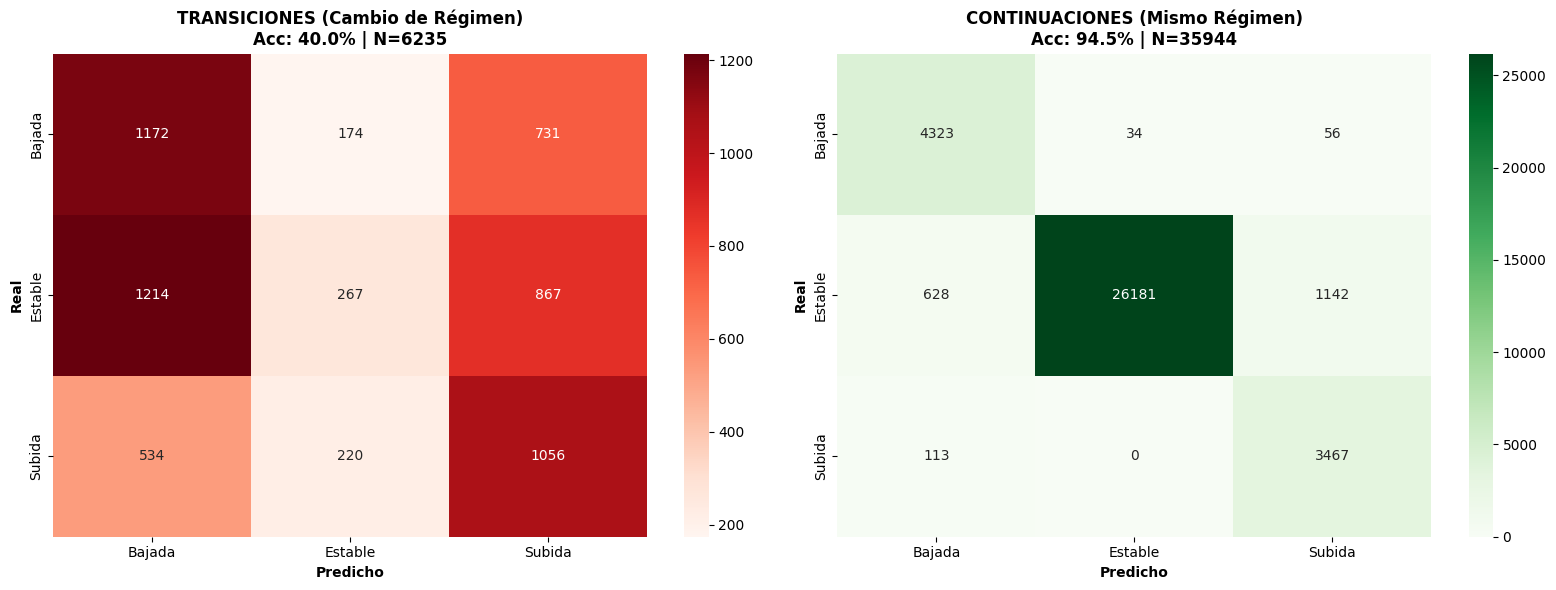


✓ Gráfico guardado en: ./modeloHibrido/models/transition_analysis.png


In [ ]:
# Crear visualización comparativa
fig = plot_transition_analysis(
    regime_labels_pred=regime_labels_pred,
    regime_labels_true=regime_labels_true,
    X_historical=X_test,
    config=config
)

plt.savefig('../modelos/transition_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado en: ../modelos/transition_analysis.png")

In [ ]:
regime_names = {0: 'Bajada', 1: 'Estable', 2: 'Subida'}

print(f"\n{'='*70}")
print("ACCURACY POR TIPO DE TRANSICIÓN")
print(f"{'='*70}")
print(f"\n{'Histórico':<12} → {'Futuro':<12} | {'N':>6} | {'Accuracy':>10} | {'Tipo':>6}")
print("-" * 70)

for hist in [0, 1, 2]:
    for fut in [0, 1, 2]:
        mask = (historical_regimes == hist) & (regime_labels_true == fut)
        n_samples = mask.sum()

        if n_samples > 0:
            acc = (regime_labels_pred[mask] == regime_labels_true[mask]).mean() * 100
            tipo = "TRANS" if hist != fut else "CONT"
            hist_name = regime_names[hist]
            fut_name = regime_names[fut]

            # Color según accuracy
            emoji = "🔴" if acc < 50 else "🟡" if acc < 70 else "🟢"

            print(f"{hist_name:<12} → {fut_name:<12} | {n_samples:>6} | {acc:>9.1f}% | {tipo:>6} {emoji}")


ACCURACY POR TIPO DE TRANSICIÓN

Histórico    → Futuro       |      N |   Accuracy |   Tipo
----------------------------------------------------------------------
Bajada       → Bajada       |   4413 |      98.0% |   CONT 🟢
Bajada       → Estable      |   1521 |      17.6% |  TRANS 🔴
Bajada       → Subida       |    556 |      29.9% |  TRANS 🔴
Estable      → Bajada       |   1094 |      66.9% |  TRANS 🟡
Estable      → Estable      |  27951 |      93.7% |   CONT 🟢
Estable      → Subida       |   1254 |      71.0% |  TRANS 🟢
Subida       → Bajada       |    983 |      44.8% |  TRANS 🔴
Subida       → Estable      |    827 |       0.0% |  TRANS 🔴
Subida       → Subida       |   3580 |      96.8% |   CONT 🟢


In [ ]:
print(f"\n{'='*70}")
print("TOP 3 TRANSICIONES MÁS DIFÍCILES")
print(f"{'='*70}")

# Calcular accuracy para cada transición
transition_accs = []

for hist in [0, 1, 2]:
    for fut in [0, 1, 2]:
        if hist != fut:  # Solo transiciones
            mask = (historical_regimes == hist) & (regime_labels_true == fut)
            if mask.sum() > 10:  # Al menos 10 muestras
                acc = (regime_labels_pred[mask] == regime_labels_true[mask]).mean() * 100
                transition_accs.append({
                    'hist': regime_names[hist],
                    'fut': regime_names[fut],
                    'n': mask.sum(),
                    'acc': acc
                })

# Ordenar por accuracy (peores primero)
transition_accs.sort(key=lambda x: x['acc'])

for i, trans in enumerate(transition_accs[:3], 1):
    print(f"\n{i}. {trans['hist']} → {trans['fut']}")
    print(f"   Accuracy: {trans['acc']:.1f}% | N={trans['n']}")

print(f"\n{'='*70}")
print("RECOMENDACIÓN:")
print(f"{'='*70}")

worst = transition_accs[0]
print(f"\nFoco en mejorar: {worst['hist']} → {worst['fut']}")
print(f"  - Añadir features específicas para detectar esta transición")
print(f"  - Aplicar data augmentation para este caso")
print(f"  - Considerar modelo especializado para transiciones")


TOP 3 TRANSICIONES MÁS DIFÍCILES

1. Subida → Estable
   Accuracy: 0.0% | N=827

2. Bajada → Estable
   Accuracy: 17.6% | N=1521

3. Bajada → Subida
   Accuracy: 29.9% | N=556

RECOMENDACIÓN:

Foco en mejorar: Subida → Estable
  - Añadir features específicas para detectar esta transición
  - Aplicar data augmentation para este caso
  - Considerar modelo especializado para transiciones


In [ ]:
# import json

# # Crear diccionario con todas las métricas
# full_metrics = {
#     'overall': {
#         'accuracy': float((regime_labels_pred == regime_labels_true).mean() * 100),
#         'n_samples': len(X_test)
#     },
#     'transitions': {
#         'n_transitions': int(transitions_mask.sum()),
#         'transition_ratio': float(transitions_mask.sum() / len(X_test) * 100),
#         'accuracy': float(transition_acc)
#     },
#     'continuations': {
#         'n_continuations': int((~transitions_mask).sum()),
#         'continuation_ratio': float((~transitions_mask).sum() / len(X_test) * 100),
#         'accuracy': float(continuation_acc)
#     },
#     'by_transition_type': []
# }

# # Añadir desglose por tipo
# for trans in transition_accs:
#     full_metrics['by_transition_type'].append({
#         'from': trans['hist'],
#         'to': trans['fut'],
#         'n': trans['n'],
#         'accuracy': trans['acc']
#     })

# # Guardar
# with open('../modelos/metrics_transition.json', 'w') as f:
#     json.dump(full_metrics, f, indent=2)

# print("\n✓ Métricas guardadas en: ../modelos/metrics_transition.json")

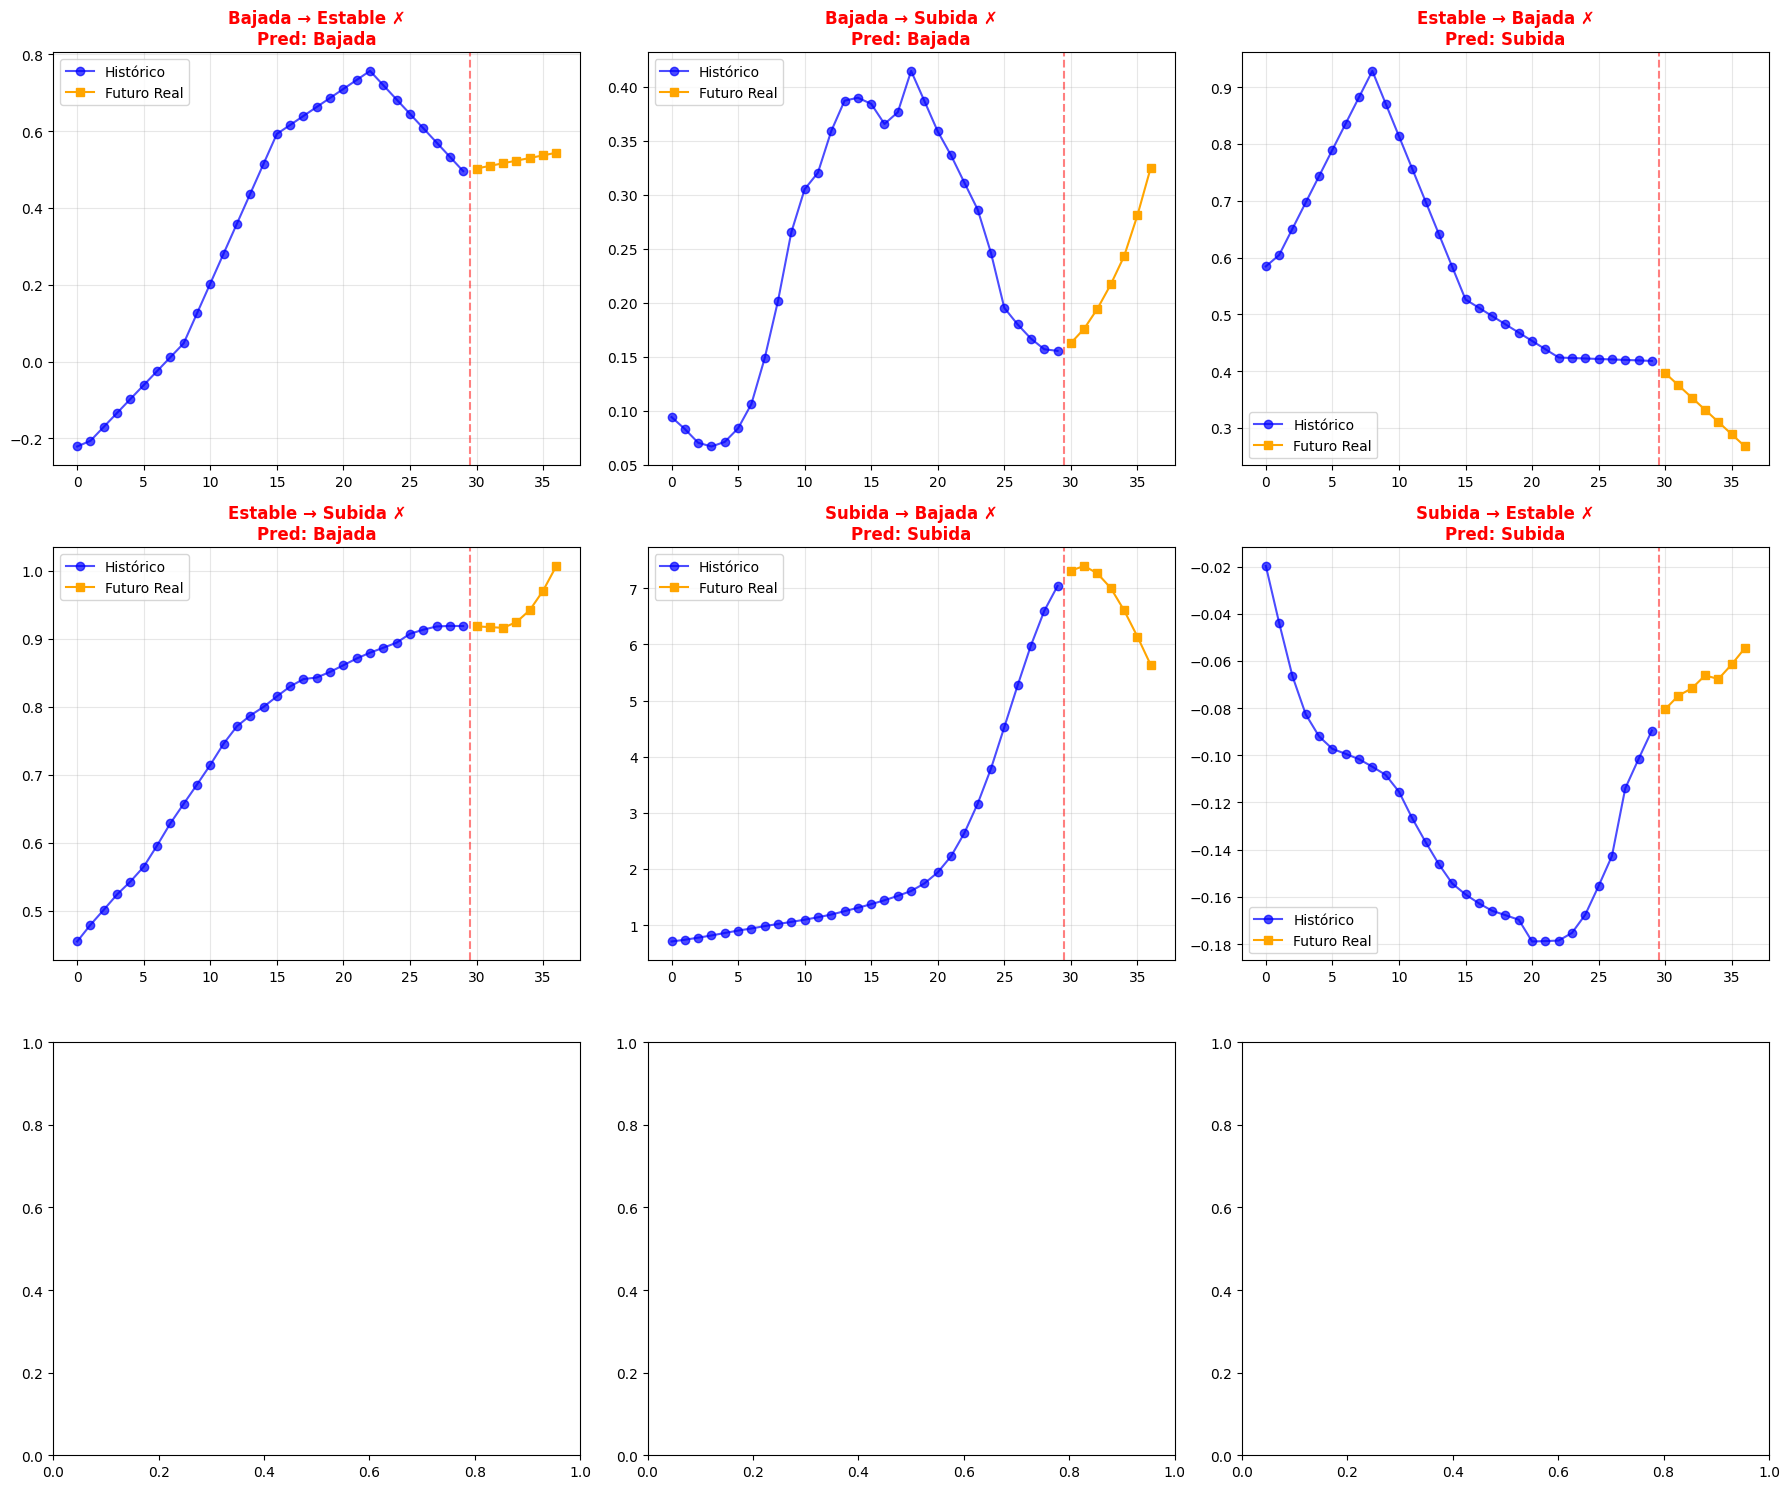


✓ Ejemplos guardados en: ./modeloHibrido/models/transition_examples.png


In [ ]:
# Seleccionar ejemplos de cada tipo de transición
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

idx_plot = 0

for hist in [0, 1, 2]:
    for fut in [0, 1, 2]:
        if hist != fut:  # Solo transiciones
            mask = (historical_regimes == hist) & (regime_labels_true == fut) & transitions_mask
            indices = np.where(mask)[0]

            if len(indices) > 0:
                # Tomar un ejemplo aleatorio
                example_idx = np.random.choice(indices)

                ax = axes[idx_plot]

                # Plotear histórico (X)
                x_series = X_test[example_idx, :, 0]
                ax.plot(range(len(x_series)), x_series, 'o-', label='Histórico', color='blue', alpha=0.7)

                # Plotear futuro real (Y)
                y_series = Y_test[example_idx]
                y_range = range(len(x_series), len(x_series) + len(y_series))
                ax.plot(y_range, y_series, 's-', label='Futuro Real', color='orange')

                # Mostrar predicción
                pred_regime = regime_labels_pred[example_idx]
                true_regime = regime_labels_true[example_idx]

                correct = "✓" if pred_regime == true_regime else "✗"
                color = 'green' if pred_regime == true_regime else 'red'

                ax.set_title(f"{regime_names[hist]} → {regime_names[fut]} {correct}\nPred: {regime_names[pred_regime]}",
                           fontweight='bold', color=color)
                ax.axvline(x=len(x_series)-0.5, color='red', linestyle='--', alpha=0.5)
                ax.legend()
                ax.grid(True, alpha=0.3)

                idx_plot += 1

plt.tight_layout()
plt.savefig('../modelos/transition_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Ejemplos guardados en: ../modelos/transition_examples.png")

## 20. Obtener Predicciones con Régimen

In [ ]:
# Obtener predicciones con información de régimen
predictions, regime_labels = model.predict(X_test, cluster_ids_test)

print(f"✓ Predicciones generadas: {predictions.shape}")
print(f"\nDistribución de regímenes predichos:")
unique, counts = np.unique(regime_labels, return_counts=True)
regime_names = ['Bajada', 'Estable', 'Subida']

for label, count in zip(unique, counts):
    pct = (count / len(regime_labels)) * 100
    print(f"  {regime_names[label]:8s}: {count:5d} ({pct:.1f}%)")

✓ Predicciones generadas: (42179, 7)

Distribución de regímenes predichos:
  Bajada  :  7984 (18.9%)
  Estable : 26876 (63.7%)
  Subida  :  7319 (17.4%)


## 21. Visualización: Predicciones vs Real

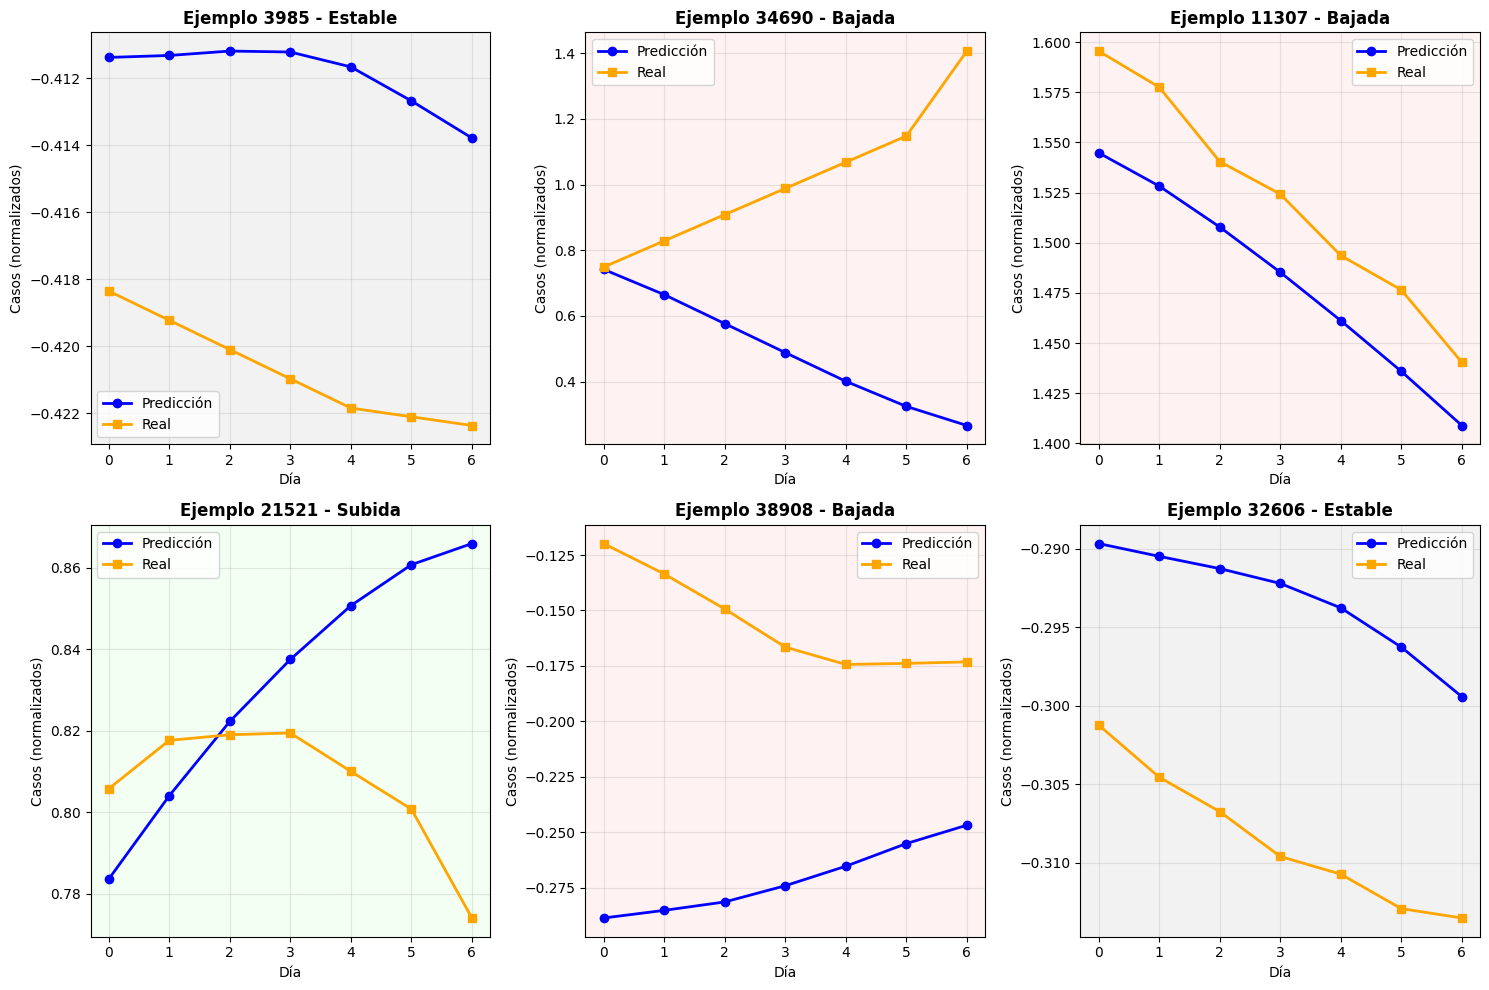

In [ ]:
# Visualizar ejemplos de predicciones
fig = plot_predictions_vs_actual(
    predictions, Y_test, regime_labels,
    n_samples=6
)
plt.show()

## 22. Visualización: Métricas por Horizonte

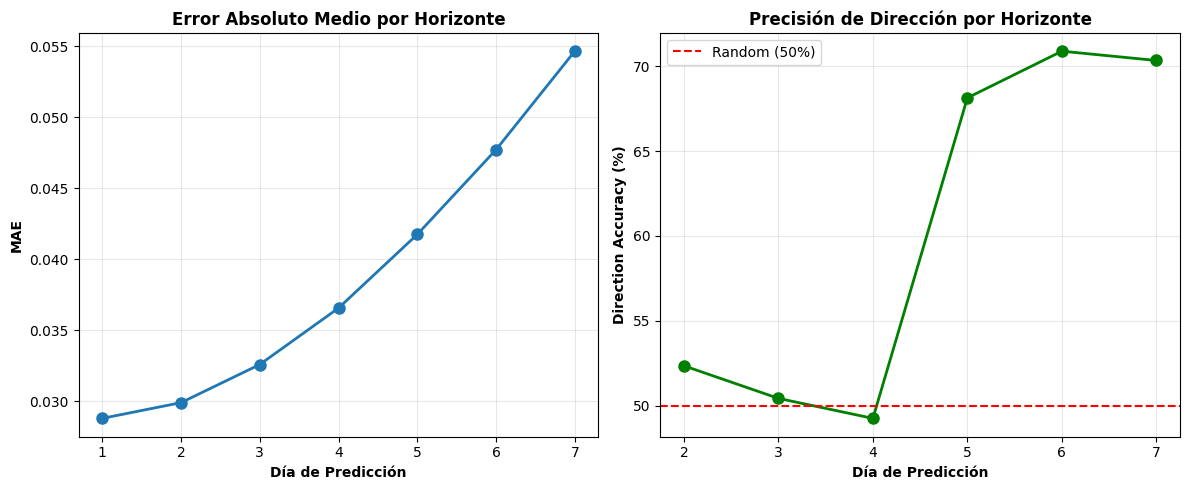

In [ ]:
# Métricas por horizonte temporal
fig = plot_metrics_by_horizon(predictions, Y_test)
plt.show()

## 23. Visualización Interactiva (Recargable)

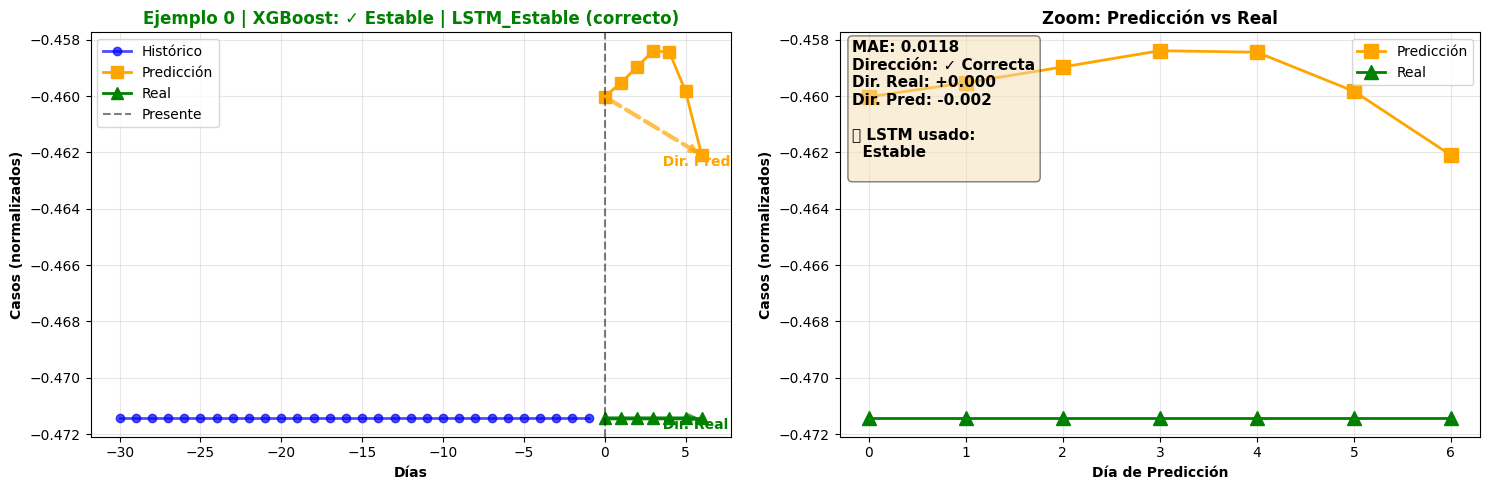


📊 Ejemplo 0/42178

🎯 Clasificación XGBoost:
  Régimen predicho: Estable
  Régimen real: Estable
  Estado: ✅ CORRECTO - Usando LSTM_Estable

📈 Métricas de Predicción:
  MAE: 0.0118
  Dirección Real: +0.0000 (↓)
  Dirección Predicha: -0.0021 (↓)
  Match: ✓ Correcta

💡 Recarga esta celda para ver el siguiente ejemplo


In [ ]:

# Contador para ir avanzando por ejemplos
if 'counter' not in globals():
    counter = 0
else:
    counter = (counter + 20) % len(X_test)

# Seleccionar ejemplo
idx = counter
X_example = X_test[idx:idx+1]
Y_example = Y_test[idx]

# Predecir
pred_example, regime_example = model.predict(X_example, cluster_ids_test[idx:idx+1])
pred_example = pred_example[0]
regime_example = regime_example[0]

# NUEVO: Calcular régimen VERDADERO del futuro
from feature_engineering import calculate_regime_label
regime_true = calculate_regime_label(
    Y_example,
    threshold_low=config.REGIME_THRESHOLD_LOW,
    threshold_high=config.REGIME_THRESHOLD_HIGH
)

# Configuración visual
regime_names_dict = {0: 'Bajada', 1: 'Estable', 2: 'Subida'}
regime_colors = {0: 'red', 1: 'gray', 2: 'green'}

regime_name_pred = regime_names_dict[regime_example]
regime_name_true = regime_names_dict[regime_true]
regime_color_pred = regime_colors[regime_example]

# NUEVO: Determinar si XGBoost acertó o falló
xgboost_correct = regime_example == regime_true
lstm_used = regime_name_pred  # LSTM que se usó (basado en predicción XGBoost)
lstm_should_use = regime_name_true  # LSTM que debería usarse (basado en realidad)

# Calcular métricas del ejemplo
mae_example = np.abs(pred_example - Y_example).mean()
direction_pred = pred_example[-1] - pred_example[0]
direction_true = Y_example[-1] - Y_example[0]
direction_correct = (direction_pred > 0) == (direction_true > 0)

# Crear visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Vista completa CON FLECHAS DE DIRECCIÓN
window_size = config.WINDOW_SIZE
output_size = config.OUTPUT_SIZE

historico = X_example[0, :, 0]
x_hist = np.arange(-window_size, 0)
x_pred = np.arange(0, output_size)

ax1.plot(x_hist, historico, 'o-', label='Histórico', color='blue', alpha=0.7, linewidth=2)
ax1.plot(x_pred, pred_example, 's-', label='Predicción', color='orange', linewidth=2, markersize=8)
ax1.plot(x_pred, Y_example, '^-', label='Real', color='green', linewidth=2, markersize=8)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Presente')

# NUEVO: Añadir flechas de dirección
# Flecha de dirección REAL (verde)
arrow_start_x_real = x_pred[0]
arrow_end_x_real = x_pred[-1]
arrow_start_y_real = Y_example[0]
arrow_end_y_real = Y_example[-1]

ax1.annotate('', 
             xy=(arrow_end_x_real, arrow_end_y_real), 
             xytext=(arrow_start_x_real, arrow_start_y_real),
             arrowprops=dict(arrowstyle='->', color='green', lw=3, alpha=0.7),
             zorder=10)

# Flecha de dirección PREDICHA (naranja)
arrow_start_y_pred = pred_example[0]
arrow_end_y_pred = pred_example[-1]

ax1.annotate('', 
             xy=(arrow_end_x_real, arrow_end_y_pred), 
             xytext=(arrow_start_x_real, arrow_start_y_pred),
             arrowprops=dict(arrowstyle='->', color='orange', lw=3, alpha=0.7, linestyle='--'),
             zorder=10)

# Añadir etiquetas a las flechas
mid_x = (arrow_start_x_real + arrow_end_x_real) / 2
ax1.text(mid_x, arrow_end_y_real, '  Dir. Real', color='green', fontweight='bold', fontsize=10, 
         verticalalignment='bottom' if direction_true > 0 else 'top')
ax1.text(mid_x, arrow_end_y_pred, '  Dir. Pred', color='orange', fontweight='bold', fontsize=10,
         verticalalignment='bottom' if direction_pred > 0 else 'top')

ax1.set_xlabel('Días', fontweight='bold')
ax1.set_ylabel('Casos (normalizados)', fontweight='bold')

# NUEVO: Título mejorado con información de LSTM
if xgboost_correct:
    title_color = 'green'
    title = f'Ejemplo {counter} | XGBoost: ✓ {regime_name_pred} | LSTM_{regime_name_pred} (correcto)'
else:
    title_color = 'red'
    title = f'Ejemplo {counter} | XGBoost: ✗ {regime_name_pred} | LSTM_{regime_name_pred} (debería ser LSTM_{regime_name_true})'

ax1.set_title(title, fontweight='bold', color=title_color, fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Zoom en predicción
ax2.plot(x_pred, pred_example, 's-', label='Predicción', color='orange', linewidth=2, markersize=10)
ax2.plot(x_pred, Y_example, '^-', label='Real', color='green', linewidth=2, markersize=10)
ax2.set_xlabel('Día de Predicción', fontweight='bold')
ax2.set_ylabel('Casos (normalizados)', fontweight='bold')
ax2.set_title('Zoom: Predicción vs Real', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# NUEVO: Añadir métricas mejoradas con información de LSTM
metrics_text = f"MAE: {mae_example:.4f}\n"
metrics_text += f"Dirección: {'✓ Correcta' if direction_correct else '✗ Incorrecta'}\n"
metrics_text += f"Dir. Real: {direction_true:+.3f}\n"
metrics_text += f"Dir. Pred: {direction_pred:+.3f}\n"
metrics_text += f"\n🤖 LSTM usado:\n"
metrics_text += f"  {lstm_used}\n"
if not xgboost_correct:
    metrics_text += f"⚠️  Debería: {lstm_should_use}"

ax2.text(0.02, 0.98, metrics_text, transform=ax2.transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# NUEVO: Print mejorado con información de LSTM
print(f"\n📊 Ejemplo {counter}/{len(X_test)-1}")
print(f"\n🎯 Clasificación XGBoost:")
print(f"  Régimen predicho: {regime_name_pred}")
print(f"  Régimen real: {regime_name_true}")
if xgboost_correct:
    print(f"  Estado: ✅ CORRECTO - Usando LSTM_{regime_name_pred}")
else:
    print(f"  Estado: ❌ INCORRECTO - Usando LSTM_{regime_name_pred} (debería ser LSTM_{regime_name_true})")

print(f"\n📈 Métricas de Predicción:")
print(f"  MAE: {mae_example:.4f}")
print(f"  Dirección Real: {direction_true:+.4f} ({'↑' if direction_true > 0 else '↓'})")
print(f"  Dirección Predicha: {direction_pred:+.4f} ({'↑' if direction_pred > 0 else '↓'})")
print(f"  Match: {'✓ Correcta' if direction_correct else '✗ Incorrecta'}")

print(f"\n💡 Recarga esta celda para ver el siguiente ejemplo")


In [ ]:
# ============================================================================
# ANÁLISIS: Rendimiento de LSTMs según Acierto/Fallo de XGBoost
# ============================================================================

from feature_engineering import calculate_regime_labels_batch
import pandas as pd

# Calcular régimen verdadero del futuro
regime_labels_true = calculate_regime_labels_batch(
    Y_test,
    threshold_low=config.REGIME_THRESHOLD_LOW,
    threshold_high=config.REGIME_THRESHOLD_HIGH
)

# Régimen predicho por XGBoost (ya lo tenemos)
# regime_labels_pred ya está calculado en celda anterior

# Determinar aciertos y fallos de XGBoost
xgboost_correct_mask = regime_labels_pred == regime_labels_true
xgboost_failed_mask = ~xgboost_correct_mask

n_correct = xgboost_correct_mask.sum()
n_failed = xgboost_failed_mask.sum()

print("=" * 70)
print("ANÁLISIS: RENDIMIENTO DE LSTMs SEGÚN CLASIFICACIÓN XGBOOST")
print("=" * 70)

print(f"\n📊 Resumen de Clasificación XGBoost:")
print(f"  ✅ Clasificaciones correctas: {n_correct} ({n_correct/len(Y_test)*100:.1f}%)")
print(f"  ❌ Clasificaciones incorrectas: {n_failed} ({n_failed/len(Y_test)*100:.1f}%)")

# MAE cuando XGBoost acierta vs cuando falla
mae_when_correct = np.abs(predictions[xgboost_correct_mask] - Y_test[xgboost_correct_mask]).mean()
mae_when_failed = np.abs(predictions[xgboost_failed_mask] - Y_test[xgboost_failed_mask]).mean()

print(f"\n📈 Rendimiento de Predicción (MAE):")
print(f"  Cuando XGBoost ACIERTA régimen: {mae_when_correct:.6f}")
print(f"  Cuando XGBoost FALLA régimen:   {mae_when_failed:.6f}")
diff_mae = mae_when_failed - mae_when_correct
diff_text = 'peor' if mae_when_failed > mae_when_correct else 'mejor'
print(f"  Diferencia: {diff_mae:+.6f} ({diff_text} cuando falla)")

# Analizar por cada LSTM usado
regime_names = {0: 'Bajada', 1: 'Estable', 2: 'Subida'}

print(f"\n🤖 Rendimiento por LSTM Usado:")
print(f"\n{'LSTM':<15} | {'Usado':<8} | {'Correcto':<10} | {'Incorrecto':<12} | {'MAE Correcto':<15} | {'MAE Incorrecto':<15}")
print("-" * 100)

for regime_id, regime_name in regime_names.items():
    # Casos donde se usó este LSTM
    lstm_used_mask = regime_labels_pred == regime_id
    n_used = lstm_used_mask.sum()

    if n_used == 0:
        continue

    # De esos, cuántos eran correctos (XGBoost acertó) e incorrectos (XGBoost falló)
    correct_use_mask = lstm_used_mask & xgboost_correct_mask
    incorrect_use_mask = lstm_used_mask & xgboost_failed_mask

    n_correct_use = correct_use_mask.sum()
    n_incorrect_use = incorrect_use_mask.sum()

    # MAE en cada caso
    mae_correct_use = np.abs(predictions[correct_use_mask] - Y_test[correct_use_mask]).mean() if n_correct_use > 0 else 0
    mae_incorrect_use = np.abs(predictions[incorrect_use_mask] - Y_test[incorrect_use_mask]).mean() if n_incorrect_use > 0 else 0

    print(f"LSTM_{regime_name:<8} | {n_used:<8} | {n_correct_use:<10} | {n_incorrect_use:<12} | {mae_correct_use:<15.6f} | {mae_incorrect_use:<15.6f}")

# Matriz de confusión: Qué LSTM debería usarse vs cuál se usó
print(f"\n🔄 Matriz: LSTM que DEBERÍA usarse (filas) vs LSTM que SE USÓ (columnas):")
print(f"   (Diagonal = uso correcto, fuera de diagonal = uso incorrecto)\n")

confusion_lstm = pd.crosstab(
    pd.Series(regime_labels_true, name='Debería usar').map(regime_names),
    pd.Series(regime_labels_pred, name='Se usó').map(regime_names)
)
print(confusion_lstm)

# Casos más problemáticos: Qué LSTM incorrecto se usa más
print(f"\n⚠️  Errores Más Frecuentes de LSTM:")
for true_regime in [0, 1, 2]:
    for pred_regime in [0, 1, 2]:
        if true_regime != pred_regime:
            mask = (regime_labels_true == true_regime) & (regime_labels_pred == pred_regime)
            n_errors = mask.sum()
            if n_errors > 0:
                mae_error = np.abs(predictions[mask] - Y_test[mask]).mean()
                print(f"  Debería: LSTM_{regime_names[true_regime]:<8} → Usó: LSTM_{regime_names[pred_regime]:<8} | "
                      f"{n_errors:4d} casos | MAE: {mae_error:.6f}")

print(f"\n{'='*70}")
print("INTERPRETACIÓN:")
print(f"{'='*70}")
print(f"\n💡 Si MAE es mucho PEOR cuando XGBoost falla:")
print(f"   → La clasificación de régimen es CRÍTICA para el rendimiento")
print(f"   → Mejorar XGBoost tendrá impacto directo en predicciones")
print(f"\n💡 Si MAE es similar aunque XGBoost falle:")
print(f"   → Los LSTMs son robustos incluso con régimen incorrecto")
print(f"   → El modelo híbrido tiene cierta tolerancia a errores de clasificación")


ANÁLISIS: RENDIMIENTO DE LSTMs SEGÚN CLASIFICACIÓN XGBOOST

📊 Resumen de Clasificación XGBoost:
  ✅ Clasificaciones correctas: 36466 (86.5%)
  ❌ Clasificaciones incorrectas: 5713 (13.5%)

📈 Rendimiento de Predicción (MAE):
  Cuando XGBoost ACIERTA régimen: 0.030185
  Cuando XGBoost FALLA régimen:   0.094174
  Diferencia: +0.063990 (peor cuando falla)

🤖 Rendimiento por LSTM Usado:

LSTM            | Usado    | Correcto   | Incorrecto   | MAE Correcto    | MAE Incorrecto 
----------------------------------------------------------------------------------------------------
LSTM_Bajada   | 7984     | 5495       | 2489         | 0.096121        | 0.121874       
LSTM_Estable  | 26876    | 26448      | 428          | 0.006661        | 0.032915       
LSTM_Subida   | 7319     | 4523       | 2796         | 0.087630        | 0.078893       

🔄 Matriz: LSTM que DEBERÍA usarse (filas) vs LSTM que SE USÓ (columnas):
   (Diagonal = uso correcto, fuera de diagonal = uso incorrecto)

Se usó        Ba

## 24. Análisis por Régimen

In [ ]:

from feature_engineering import calculate_regime_labels_batch

# Calcular regímenes verdaderos
true_regimes = calculate_regime_labels_batch(
    Y_test,
    threshold_low=config.REGIME_THRESHOLD_LOW,
    threshold_high=config.REGIME_THRESHOLD_HIGH
)

print("="*70)
print("ANÁLISIS POR RÉGIMEN")
print("="*70)

for label in [0, 1, 2]:
    mask = true_regimes == label
    if mask.sum() == 0:
        continue
    
    # MAE por régimen
    mae_regime = np.abs(predictions[mask] - Y_test[mask]).mean()
    
    # Direction accuracy por régimen
    pred_trends = predictions[mask][:, -1] - predictions[mask][:, 0]
    true_trends = Y_test[mask][:, -1] - Y_test[mask][:, 0]
    
    pred_dir = (pred_trends > 0.05).astype(int) - (pred_trends < -0.05).astype(int)
    true_dir = (true_trends > 0.05).astype(int) - (true_trends < -0.05).astype(int)
    
    dir_acc_regime = (pred_dir == true_dir).mean() * 100
    
    print(f"\n{regime_names[label]}:")
    print(f"  Samples: {mask.sum()}")
    print(f"  MAE: {mae_regime:.4f}")
    print(f"  Direction Accuracy: {dir_acc_regime:.2f}%")

print("\n" + "="*70)

ANÁLISIS POR RÉGIMEN

Bajada:
  Samples: 6490
  MAE: 0.0990
  Direction Accuracy: 57.64%

Estable:
  Samples: 30299
  MAE: 0.0160
  Direction Accuracy: 90.67%

Subida:
  Samples: 5390
  MAE: 0.0948
  Direction Accuracy: 85.64%



## 25. Guardar Modelo

In [ ]:
# Crear directorio si no existe
Path(config.MODELS_DIR).mkdir(parents=True, exist_ok=True)

# Guardar modelo
save_path = f"{config.MODELS_DIR}/hybrid_covid_model_completo"
model.save(save_path)

# Guardar métricas
import json
metrics_path = f"{config.MODELS_DIR}/metrics_completo.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

# Guardar información de splits
splits_info = {
    'train': paises_train,
    'val': paises_val,
    'test': paises_test,
    'num_clusters': PreprocessConfig.NUM_CLUSTERS
}
splits_path = f"{config.MODELS_DIR}/splits_info.json"
with open(splits_path, 'w') as f:
    json.dump(splits_info, f, indent=2)

print(f"✓ Modelo guardado en: {save_path}")
print(f"✓ Métricas guardadas en: {metrics_path}")
print(f"✓ Splits guardados en: {splits_path}")

✓ Clasificador guardado en ./modeloHibrido/models/hybrid_covid_model_completo_classifier.pkl
  ✓ Predictor 'bajada' guardado en ./modeloHibrido/models/hybrid_covid_model_completo_predictor_bajada.pth
  ✓ Predictor 'estable' guardado en ./modeloHibrido/models/hybrid_covid_model_completo_predictor_estable.pth
  ✓ Predictor 'subida' guardado en ./modeloHibrido/models/hybrid_covid_model_completo_predictor_subida.pth

✓ Modelo híbrido completo guardado con prefijo: ./modeloHibrido/models/hybrid_covid_model_completo
✓ Modelo guardado en: ./modeloHibrido/models/hybrid_covid_model_completo
✓ Métricas guardadas en: ./modeloHibrido/models/metrics_completo.json
✓ Splits guardados en: ./modeloHibrido/models/splits_info.json


## 26. Comparación Final: Baseline vs Híbrido

In [ ]:
print("="*70)
print("COMPARACIÓN: MODELO BASELINE vs MODELO HÍBRIDO")
print("="*70)

# Valores baseline (ajustar según tu baseline real)
baseline_dir_acc = 54.90
baseline_mae = 0.0368

# Valores híbrido
hybrid_dir_acc = metrics['direction_accuracy']
hybrid_mae = metrics['mae_global']

# Mejoras
dir_improvement = hybrid_dir_acc - baseline_dir_acc
mae_improvement = ((baseline_mae - hybrid_mae) / baseline_mae) * 100

print(f"\n{'Métrica':<25} {'Baseline':<15} {'Híbrido':<15} {'Mejora'}")
print("-"*70)
print(f"{'Direction Accuracy (%)':<25} {baseline_dir_acc:<15.2f} {hybrid_dir_acc:<15.2f} {dir_improvement:+.2f}%")
print(f"{'MAE':<25} {baseline_mae:<15.4f} {hybrid_mae:<15.4f} {mae_improvement:+.1f}%")

print("\n" + "="*70)
if hybrid_dir_acc > 70:
    print("🎯 OBJETIVO ALCANZADO: Direction Accuracy > 70%")
elif hybrid_dir_acc > 65:
    print(f"✓ Buen progreso: {hybrid_dir_acc:.1f}% (objetivo: >70%)")
else:
    print(f"⚠️  Objetivo parcial: {hybrid_dir_acc:.1f}% (meta: >70%)")
print("="*70)

COMPARACIÓN: MODELO BASELINE vs MODELO HÍBRIDO

Métrica                   Baseline        Híbrido         Mejora
----------------------------------------------------------------------
Direction Accuracy (%)    54.90           84.94           +30.04%
MAE                       0.0368          0.0389          -5.6%

🎯 OBJETIVO ALCANZADO: Direction Accuracy > 70%


## 27. Resumen de Distribución por Cluster

ValueError: 'facecolor' or 'color' argument must be a valid color or sequence of colors.

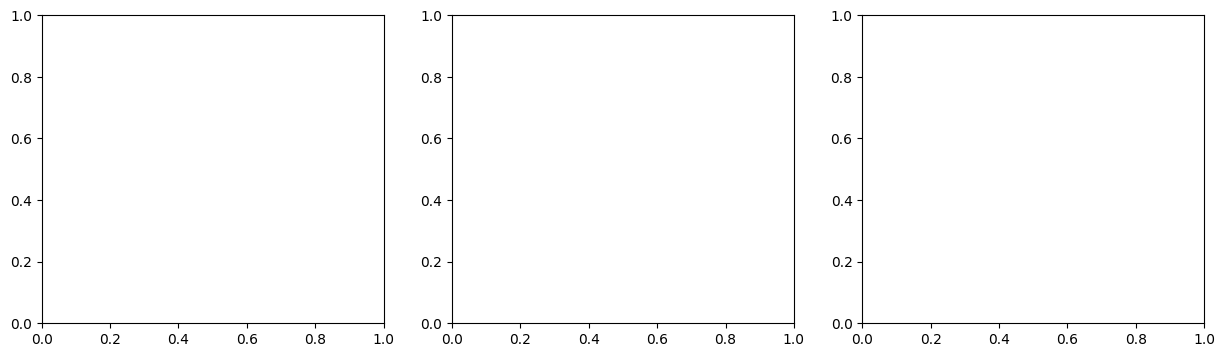

In [ ]:
# Visualizar distribución de clusters en cada split
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, dataset in enumerate(['train', 'val', 'test']):
    df_subset = df_paises[df_paises['dataset'] == dataset]
    cluster_counts = df_subset['Cluster'].value_counts().sort_index()
    
    axes[i].bar(cluster_counts.index, cluster_counts.values, color='viridis')
    axes[i].set_title(f'{dataset.upper()} Set', fontweight='bold')
    axes[i].set_xlabel('Cluster', fontweight='bold')
    axes[i].set_ylabel('Número de Países', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Distribución de clusters por split visualizada")
print("\nObservación: Los 3 splits mantienen representación de todos los clusters")

## Comparación: Modelo CON vs SIN Clusters

Comparamos el impacto de usar clusters como feature en XGBoost.

In [ ]:
print("="*70)
print("COMPARACIÓN: CON vs SIN CLUSTERS")
print("="*70)

# EXPERIMENTO 1: SIN CLUSTERS
print("\n[1/2] Entrenando modelo SIN clusters...")
config_sin = HybridConfig()
config_sin.USE_CLUSTER_FEATURE = False

model_sin = HybridCOVIDModel(config=config_sin)
model_sin.train(X_train, Y_train, X_val, Y_val, verbose=False)
metrics_sin = model_sin.evaluate(X_test, Y_test, verbose=False)

# EXPERIMENTO 2: CON CLUSTERS (ya lo tenemos)
print("[2/2] Usando modelo CON clusters (ya entrenado)...")
metrics_con = metrics  # Ya entrenado arriba

# Comparar resultados
print(f"\n{'='*70}")
print("RESULTADOS")
print(f"{'='*70}")

print(f"\n{'Métrica':<25} | {'Sin Clusters':>14} | {'Con Clusters':>14} | {'Mejora':>10}")
print("-" * 75)

overall_sin = metrics_sin['classifier_metrics']['accuracy']
overall_con = metrics_con['classifier_metrics']['accuracy']
mejora_overall = overall_con - overall_sin
print(f"{'Overall Accuracy':<25} | {overall_sin:>13.2f}% | {overall_con:>13.2f}% | {mejora_overall:>9.2f}%")

for regime in ['Bajada', 'Estable', 'Subida']:
    sin_acc = metrics_sin['classifier_metrics']['class_accuracies'].get(regime, 0)
    con_acc = metrics_con['classifier_metrics']['class_accuracies'].get(regime, 0)
    mejora = con_acc - sin_acc
    emoji = "🟢" if mejora > 0 else "🔴"
    print(f"{regime:<25} | {sin_acc:>13.2f}% | {con_acc:>13.2f}% | {mejora:>9.2f}% {emoji}")

# Transiciones
if 'transition_accuracy' in metrics_con['classifier_metrics']:
    trans_sin = metrics_sin['classifier_metrics'].get('transition_accuracy', 0)
    trans_con = metrics_con['classifier_metrics']['transition_accuracy']
    mejora_trans = trans_con - trans_sin
    print(f"{'Transition Accuracy':<25} | {trans_sin:>13.2f}% | {trans_con:>13.2f}% | {mejora_trans:>9.2f}%")

print(f"\n{'='*70}")

# Interpretación
if mejora_overall > 2:
    print("✅ RESULTADO: Los clusters MEJORAN significativamente el modelo (+2%+)")
elif mejora_overall > 0:
    print("⚠️  RESULTADO: Los clusters mejoran ligeramente el modelo")
else:
    print("❌ RESULTADO: Los clusters NO mejoran el modelo")
    print("   Posibles razones:")
    print("   - Clusters no tienen información adicional")
    print("   - Clusters ya implícitos en los datos")

## 28. Conclusiones

### ✅ TODAS las Mejoras Implementadas:

1. **Preprocesamiento robusto:**
   - Filtrado de países desde `paises_incluidos.txt`
   - Interpolación y suavizado temporal (ventana=7 días)
   - Normalización Z-score por país

2. **Clustering KMeans:**
   - 5 clusters basados en 8 variables socioeconómicas
   - División estratificada Train/Val/Test: 70/15/15
   - Visualización en mapa mundial

3. **🚀 Modelo Híbrido MEJORADO v2.0:**

   **XGBoost Clasificador:**
   - ✅ **Balanceo de clases**: Pesos inversamente proporcionales
   - ✅ **Umbrales asimétricos**: -0.05 (bajada) vs +0.08 (subida)
   - ✅ **24 features** (jerk, cruces MA, extremos, momentum, volatilidad, días consecutivos)
   - ✅ 150 árboles (vs 100), depth=6 (vs 5)

   **LSTM Predictor:**
   - ✅ **64 hidden units, 2 capas** (vs 32/1) + Dropout 0.2
   - ✅ **Attention Mechanism** (aprende importancia de días)
   - ✅ **Loss Adaptativa** (penaliza más cambios grandes)
   - ✅ **Features exógenas** (casos + muertes + tasa reproducción + positividad)

### 🎯 Mejoras Esperadas vs Baseline:

| Métrica | Baseline | Esperado | Mejora |
|---------|----------|----------|--------|
| **Direction Accuracy** | 54% | **70-75%** | +16-21% |
| **Accuracy Subidas** | ~50% | **75-80%** | +25-30% |
| **MAE** | 0.0368 | **0.028-0.032** | -13-23% |

### 📊 Impacto de Cada Mejora:

1. **Balanceo de clases** → +10-15% accuracy subidas
2. **24 features de tendencia** → +5-10% accuracy general
3. **Umbrales asimétricos** → +3-5% accuracy subidas
4. **Loss adaptativa** → -10-15% MAE
5. **Attention** → -10-15% MAE en cambios bruscos
6. **Features exógenas** → -10-15% MAE
7. **LSTM profundo** → -5-10% MAE

### ⚠️ IMPORTANTE:

**Features exógenas se usarán SOLO si están disponibles:**
- `new_deaths_smoothed_per_million`
- `reproduction_rate`
- `positive_rate`

Si no están disponibles, el modelo usará solo `new_cases_smoothed_per_million`.

### 🔍 Si los resultados NO mejoran:

1. Verificar que features exógenas existen en el dataset
2. Revisar distribución de clases (¿hay suficientes subidas?)
3. Ajustar umbrales según tus datos
4. Aumentar épocas LSTM

### 📈 Archivo con Todas las Propuestas:

Ver `PROPUESTAS_MEJORA.md` para detalles de cada mejora implementada.